**<font color = 'green'>**Desafío - Enfermedad en la sangre**</font>**

# 1.Importa las librerías necesarias para entrenar modelos de regresión logística con validación cruzada y Extreme Gradient Boosting, carga los datos y repáralos.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocesamiento
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

#Modelos
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold

#Evaluacion
from sklearn.metrics import confusion_matrix,classification_report, roc_auc_score,average_precision_score, roc_curve, precision_recall_curve

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Redes neuronales/3.Modelos de ensamble Parte III/Desafio/hcvdat0.csv")

1. X (Patient ID/No.):      Número o identificación única asociada a cada paciente en la base de datos.
2. Category (diagnosis):      Categoría que indica el diagnóstico relacionado con la hepatitis C para cada paciente.
3. Age (in years):      Edad del paciente en años al momento de la detección o registro en la base de datos.
4. Sex (f,m):      Género del paciente, indicado por "f" para femenino y "m" para masculino.
5. ALB:      Albúmina, una proteína producida por el hígado. Los niveles de albúmina
pueden indicar la función hepática.
6. ALP: Fosfatasa alcalina, una enzima que puede estar relacionada con la función hepática y otros procesos.
7. ALT: Alanina aminotransferasa, una enzima que puede indicar daño hepático.
8. AST: Aspartato aminotransferasa, una enzima que también puede indicar daño
hepático.
9. BIL: Bilirrubina, un pigmento amarillo que puede aumentar en casos de problemas hepáticos.
10. CHE: Colinesterasa, una enzima que puede estar asociada con la función hepática y otros procesos.
11. CHOL: Colesterol, un lípido que puede estar relacionado con la salud del hígado.
12. CREA: Creatinina, un producto de desecho que se filtra a través de los riñones.
13. GGT: Gamma-glutamil transferasa, una enzima que puede estar relacionada con la función hepática.
14. PROT: Proteínas totales, que pueden incluir varias proteínas, como albúmina y globulinas.

In [ ]:
df.dtypes

Unnamed: 0      int64
Category       object
Age             int64
Sex            object
ALB           float64
ALP           float64
ALT           float64
AST           float64
BIL           float64
CHE           float64
CHOL          float64
CREA          float64
GGT           float64
PROT          float64
dtype: object

**a. elimina la columna Unnamed: 0.**



*   a. elimina la columna Unnamed: 0.
*   b. codifica la variable Category en  (target) según lo indicado
*   c. codifica la variable Category en  (suspect) según lo indicado
*   d. Revisa si la base de datos contiene valores ausentes. En caso que sea así,aplica los siguientes criterios:
i. si el porcentaje de valores ausentes para alguna variable es menor a
1%, entonces elimina las filas que contengan estos valores ausentes
ii. si el porcentaje de valores ausentes es mayor, entonces reemplaza
estos por el promedio según la clase a la que pertenezca el valor
ausente.


In [ ]:
df = df.drop(columns="Unnamed: 0") #a
df["target"] = np.where(df["Category"]=="0=Blood Donor",0,1) #b
df["suspect"] = np.where(df["Category"]=='0s=suspect Blood Donor',1,0) #c
df = df.drop(columns="Category") #a

In [ ]:
#d.i | d.ii, primero revisamos la cantidad de nulos por columnas
total = df.shape[0]
per = total*0.01

print(f"Con un total de registros de {total}, el 1% representa {per} registros:")
print()

for col in df.columns:
  nulls = df[col].isnull().sum()
  if nulls == 0:
    print(f"La columna {col} no contiene nulos")
  elif nulls > per:
    print(f"La columna {col} SUPERA el 1% de registros nulos con {nulls}, se deberá imputar la media por clase")
  else:
    print(f"La columna {col} NO SUPERA el 1% de registros nulos con {nulls}, se deberán eliminar los registros nulos")


Con un total de registros de 615, el 1% representa 6.15 registros:

La columna Age no contiene nulos
La columna Sex no contiene nulos
La columna ALB NO SUPERA el 1% de registros nulos con 1, se deberán eliminar los registros nulos
La columna ALP SUPERA el 1% de registros nulos con 18, se deberá imputar la media por clase
La columna ALT NO SUPERA el 1% de registros nulos con 1, se deberán eliminar los registros nulos
La columna AST no contiene nulos
La columna BIL no contiene nulos
La columna CHE no contiene nulos
La columna CHOL SUPERA el 1% de registros nulos con 10, se deberá imputar la media por clase
La columna CREA no contiene nulos
La columna GGT no contiene nulos
La columna PROT NO SUPERA el 1% de registros nulos con 1, se deberán eliminar los registros nulos
La columna target no contiene nulos
La columna suspect no contiene nulos


In [ ]:
#Dropeamos los nulos de las columnas con menos de 1% primero
df = df.dropna(subset=["ALB","PROT","ALT"])

#Calculamos la media por clase para cada columna
df_temp = df.dropna()
target_0 = df_temp.query("target==0")
target_1 = df_temp.query("target==1")

alp_0 = target_0["ALP"].mean()
alp_1 = target_1["ALP"].mean()

chol_0 = target_0["CHOL"].mean()
chol_1 = target_1["CHOL"].mean()

print(f"ALP 0: {alp_0}  ALP 1: {alp_1}")
print(f"CHOL 0: {chol_0}  CHOL 1: {chol_1}")

ALP 0: 68.16330798479088  ALP 1: 67.7873015873016
CHOL 0: 5.494315589353612  CHOL 1: 4.5315873015873


In [ ]:
#Imputamos las medias calculadas
df["ALP"] = np.where((df["ALP"].isnull()) & (df["target"]==0), alp_0, df["ALP"])
df["ALP"] = np.where((df["ALP"].isnull()) & (df["target"]==1), alp_1, df["ALP"])
df["ALP"] = df["ALP"].round()

df["CHOL"] = np.where((df["CHOL"].isnull()) & (df["target"]==0), chol_0, df["CHOL"])
df["CHOL"] = np.where((df["CHOL"].isnull()) & (df["target"]==1), chol_1, df["CHOL"])

Transformaremos los nombres de las columnas para poder comprender de manera más rapida que representan

In [ ]:
old_names = df.columns.to_list()
name_replace = ["age","sex","albumina","fosfatasa_alcalina","alanina","aspartato","bilirrubina","colinesterasa","colesterol","creatinina","gamma_glutamil","proteinas_tol","target","suspect"]
df = df.rename(columns=dict(zip(old_names,name_replace)))

e. Realiza un analisis descriptivo para cada variable, usando graficos para representar distribuciones y boxplot. Construye un heatmap para mostrar correlaciones y comenta.

In [ ]:
#Transformaremos target y suspect a booleana solo para visualizacion, luego continuaremos con el df normal
df_vis = df.copy()
df_vis["target"] = df_vis["target"].astype(bool)
df_vis["suspect"] = df_vis["suspect"].astype(bool)


def get_graphics_uni(df,dfname):
  print(f"Graficos del dataset {dfname}")
  print()
  fig,axs = plt.subplots(4,4,figsize=(20,10))

  for index, colname in enumerate(df.columns):
    if df[colname].dtypes in ["object","bool"]:
      #Calculamos la freq promedio

      plt.subplot(4,4,index+1)
      sns.countplot(data=df,x=df[colname],color="grey",alpha=0.3)
      plt.title(f"Frecuencia de {colname}")
      plt.tight_layout()

    else:
      plt.subplot(4,4,index+1)
      mean = df[colname].mean()
      sns.boxplot(x=df[colname],orient="horizontal",width=0.4,
                    boxprops=dict(facecolor="skyblue", alpha=0.3),
                    flierprops=dict(markerfacecolor='grey', markeredgecolor='grey',marker="x",linewidth=1))
      plt.axvline(mean,ls="dashed",lw=0.8,color="tomato",label=f"Mean {round(mean,2)}")
      plt.legend(loc="upper center")
      plt.title(f"Distribución de {colname}")
      plt.xlabel("Value")
      plt.ylabel(colname)
      plt.tight_layout()

In [ ]:
#Calculo % categoricas
cat = df_vis[["sex","target","suspect"]]
for col in cat:
  print(f"{df[col].value_counts('%')}")

sex
m    0.611111
f    0.388889
Name: proportion, dtype: float64
target
0    0.870915
1    0.129085
Name: proportion, dtype: float64
suspect
0    0.988562
1    0.011438
Name: proportion, dtype: float64


Graficos del dataset Deteccion de enfermedad en sangre



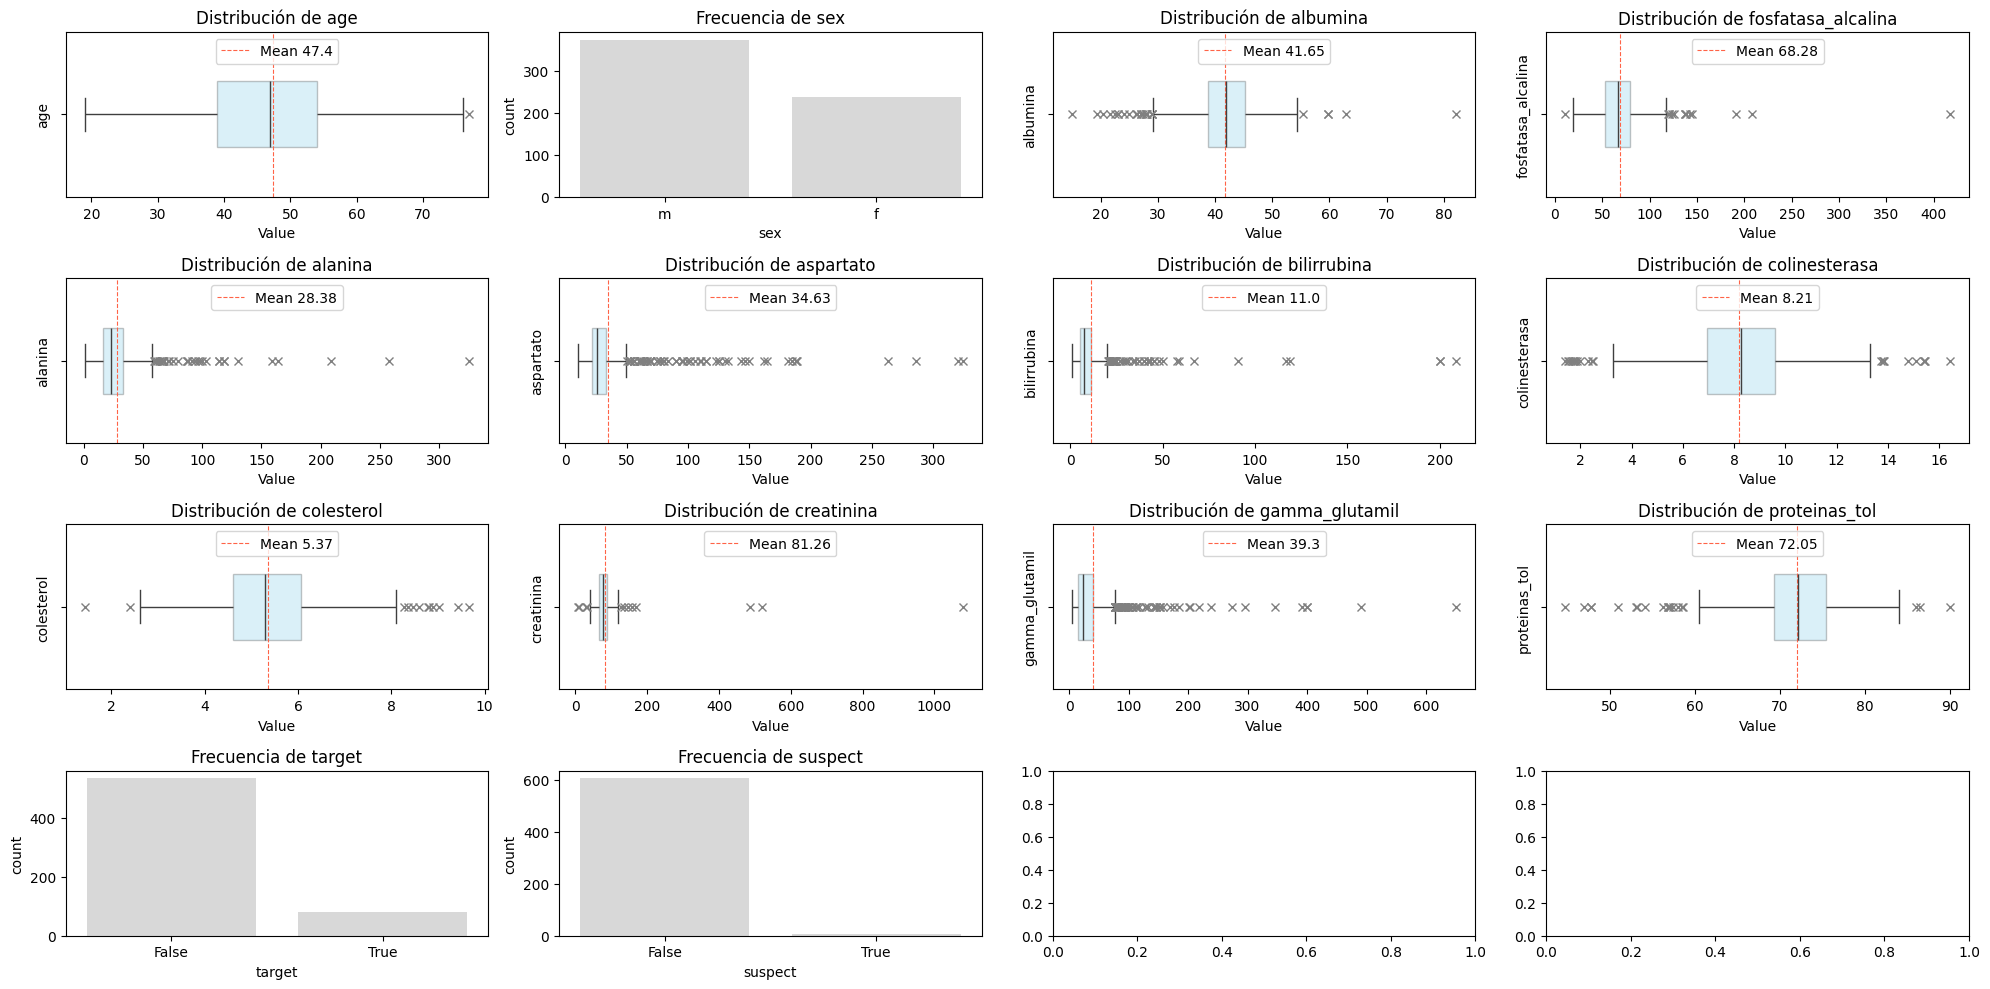

In [ ]:
get_graphics_uni(df_vis,"Deteccion de enfermedad en sangre")

**Observaciones:**

**Categoricas:**
*  Un 61% de los registros corresponden a hombres, lo que podría generar algún tipo de sesgo o conclusion errada al no existir paridad en la frecuencia de sexos.
*  El target cuenta con un desbalance de clases de 87-13%
*  Los sospechosos de enfermedad en sangre corresponden al 0.01%

**Numericas:**
*  La edad distribuye normal y el rango entre 40 y 55 años contiene la mitad de los datos.
*  El rango entre 40 y 45 de Albumina presenta la mayor cantidad de datos.
*  Fosfatasa, alanina, aspartato, bilirrubina, creatinina y gamma presentan un sesgo a la derecha en su distribución
*  Colesterol tiende a distribuir de manera normal entre 4,5 y 6.
*  Proteinas total presenta sesgo a la izquierda.



**IMPORTANTE: Luego de una primera ejecución y visualizados los resultados luego de aplicar una limpieza de outliers, está no aporta de manera correcta a  los modelos ya que elimina muchos registros del target 1, bajando del 13% al 2%,; esto refleja que los "outliers" vistos son precisamente los valores que caracterizan a un target 1, por lo que no los eliminaremos. Sumado a todo eso, la data es muy pequeña como para poder dejar ir casi un 20% de la data con una limpieza.**

In [ ]:
df_vis

,age,sex,albumina,fosfatasa_alcalina,alanina,aspartato,bilirrubina,colinesterasa,colesterol,creatinina,gamma_glutamil,proteinas_tol,target,suspect
0,32,m,38.5,52.0,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0,False,False
1,32,m,38.5,70.0,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5,False,False
2,32,m,46.9,75.0,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3,False,False
3,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7,False,False
4,32,m,39.2,74.0,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,62,f,32.0,417.0,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5,True,False
611,64,f,24.0,103.0,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3,True,False
612,64,f,29.0,87.0,3.5,99.0,48.0,1.66,3.63,66.7,64.2,82.0,True,False
613,46,f,33.0,68.0,39.0,62.0,20.0,3.56,4.20,52.0,50.0,71.0,True,False


**Analisis bi-variado**

Para visualizar como se comportan las variables contra el target, graficaremos algunas.

Text(0.5, 1.0, 'Proteinas total by target')

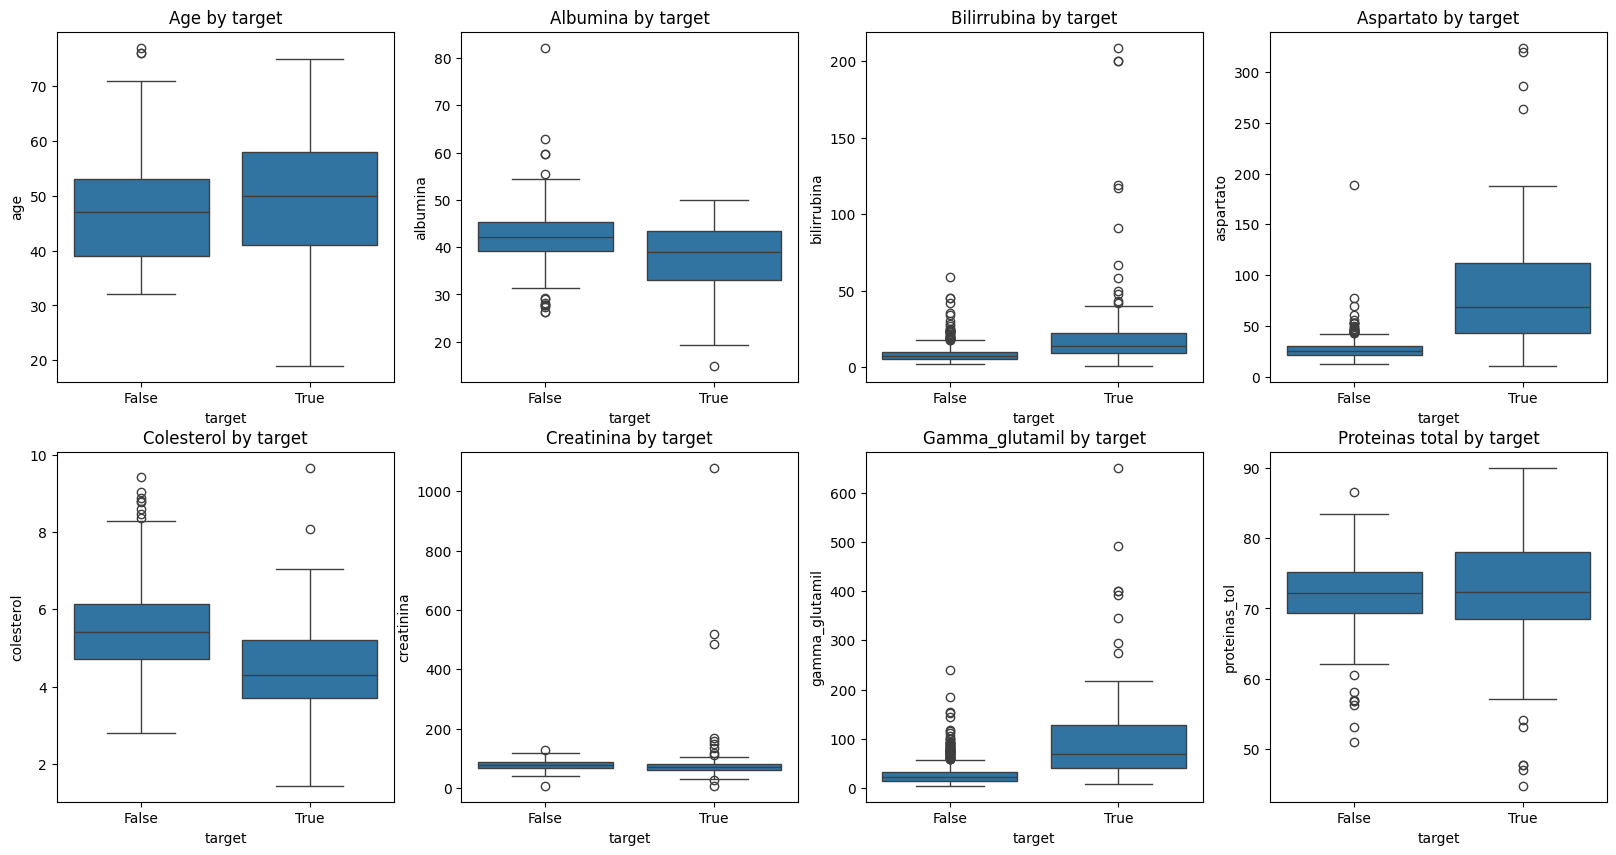

In [ ]:
fig, axs = plt.subplots(2,4,figsize=(20,10))

sns.boxplot(data=df_vis,x="target",y="age",ax=axs[0,0])
axs[0,0].set_title("Age by target")
sns.boxplot(data=df_vis,x="target",y="albumina",ax=axs[0,1])
axs[0,1].set_title("Albumina by target")
sns.boxplot(data=df_vis,x="target",y="bilirrubina",ax=axs[0,2])
axs[0,2].set_title("Bilirrubina by target")
sns.boxplot(data=df_vis,x="target",y="aspartato",ax=axs[0,3])
axs[0,3].set_title("Aspartato by target")

sns.boxplot(data=df_vis,x="target",y="colesterol",ax=axs[1,0])
axs[1,0].set_title("Colesterol by target")
sns.boxplot(data=df_vis,x="target",y="creatinina",ax=axs[1,1])
axs[1,1].set_title("Creatinina by target")
sns.boxplot(data=df_vis,x="target",y="gamma_glutamil",ax=axs[1,2])
axs[1,2].set_title("Gamma_glutamil by target")
sns.boxplot(data=df_vis,x="target",y="proteinas_tol",ax=axs[1,3])
axs[1,3].set_title("Proteinas total by target")


**Observaciones analisis bi-variado**:



* A pesar de poder visualizar algunas diferencias de distribución de algunas variables con respecto al target, no se aprecian diferencias notables entre estas, más allá del "aspartato" y "gamma_glutamil, y eventualmente la bilirrubina.



**Graficaremos correlaciones**

<Axes: >

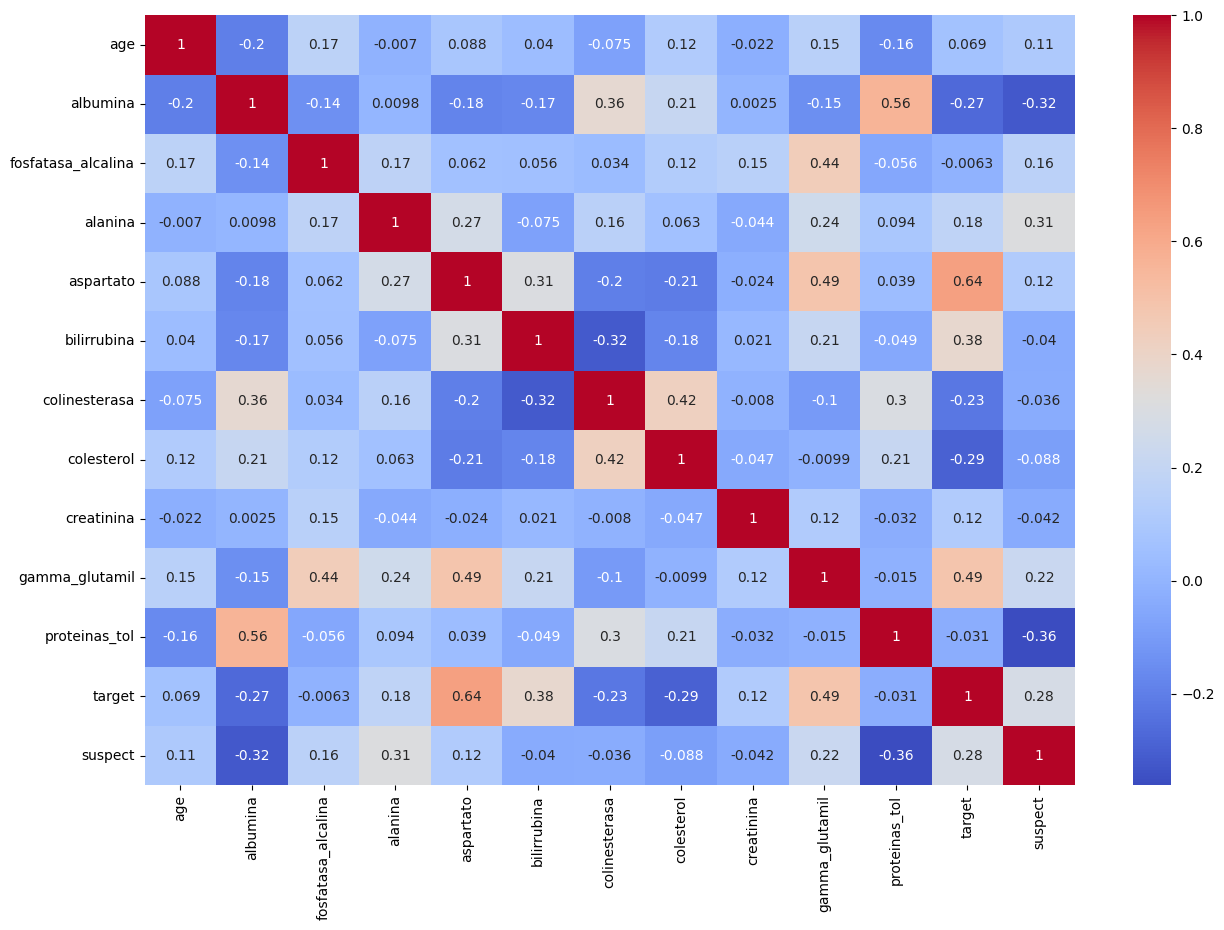

In [ ]:
#Calculamos la correlacion de Pearson
df_cor = df.corr(numeric_only=True)

plt.figure(figsize=(15,10))
sns.heatmap(df_cor,annot=True,cmap="coolwarm")

**Observaciones correlaciones:**
* No se observan correlaciones extremadamente altas entre las distintas variables, lo que nos permite inferir que no existe multicolinealidad entre ellas; por lo que podemos destacar las correlaciones:
* edad contra el nivel alto de colesterol,
* nivel de albumina contra proteinas total, pero sin embargo total de proteinas deberia incluir esta, por lo que podría eliminarse eventualmente,
* alanina contra espartato con una buena correlacion positiva de más de 50%
* gamma glutamil con alanina, con una corr positiva de 0,42.

* Como pudimos ver anteriormente en el analis bi-variado, aspartato y gamma_glutamil presentan buena correlacion contra el target, ambas al parecer son variables importantes para predecir la presencia o no de enfermedad en sangre.

**f.Transforma las variables regresoras por medio de la estandarización. Muestra el antes y después de esta usando boxplots, y realiza una segmentación de la muestra en 33% para test y el resto para entrenamien**

In [ ]:
#Antes de la estandarizacion modificaremos algunas variables, como sex a integer para no hacer un dummies
df["sex"] = np.where(df["sex"]=="m",1,0)

Graficos del dataset Regresores Antes de la estandarizacion



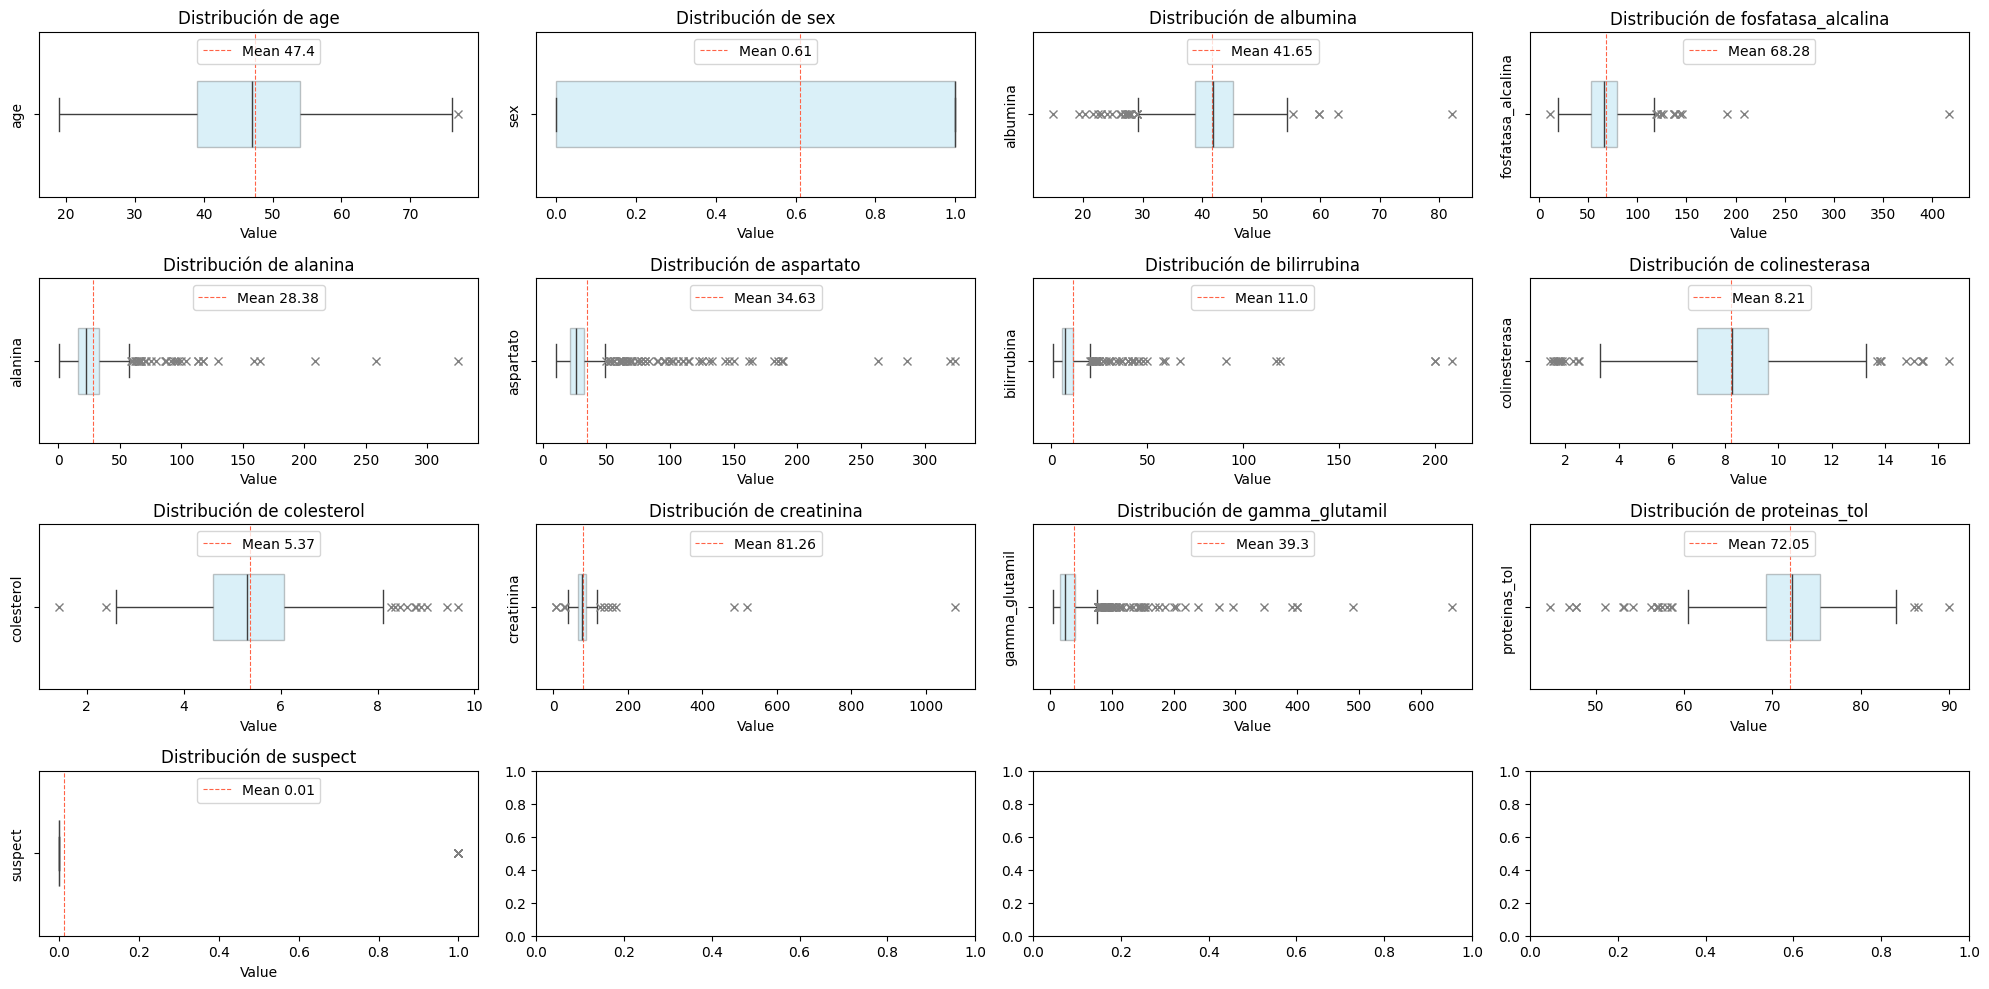

In [ ]:
#Regresores antes de la estandarizacion
reg_before = df.drop(columns="target")
get_graphics_uni(reg_before,"Regresores Antes de la estandarizacion")

In [ ]:
# Seleccionar solo las características numéricas continuas para estandarizar
numeric_features = ["age","albumina","fosfatasa_alcalina","alanina","aspartato","bilirrubina","colinesterasa","colesterol","creatinina","gamma_glutamil","proteinas_tol"]
numeric_data = df[numeric_features]

# Estandarizar las características numéricas continuas
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(numeric_data)

# Visualizamos
df

,age,sex,albumina,fosfatasa_alcalina,alanina,aspartato,bilirrubina,colinesterasa,colesterol,creatinina,gamma_glutamil,proteinas_tol,target,suspect
0,-1.533722,1,-0.550964,-0.633749,-0.812461,-0.379878,-0.205131,-0.582446,-1.898672,0.496645,-0.498726,-0.565687,0,0
1,-1.533722,1,-0.550964,0.066911,-0.407746,-0.301052,-0.415827,1.352217,-0.503859,-0.145698,-0.434542,0.826465,0,0
2,-1.533722,1,0.918274,0.261539,0.307382,0.544813,-0.287068,0.289065,-0.148493,0.095181,-0.111786,1.346202,0,0
3,-1.533722,1,0.271109,-0.633749,0.087343,-0.364719,0.462075,-0.399931,-0.557164,-0.025259,-0.100783,0.677969,0,0
4,-1.533722,1,-0.428528,0.222613,0.165928,-0.298020,-0.082224,0.430514,-0.930299,-0.105552,-0.172303,-0.621373,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,1.454618,0,-1.687874,13.574074,-0.883188,2.294146,2.282259,-1.202999,0.828764,-0.513039,11.215840,-0.658497,1,0
611,1.653841,0,-3.087149,1.351454,-1.001066,0.296207,0.526454,-3.041842,-2.085239,-0.366504,-0.062273,-0.138760,1,0
612,1.653841,0,-2.212602,0.728645,-0.977490,1.951555,2.165205,-2.987087,-1.543305,-0.292233,0.456704,1.847377,1,0
613,-0.139163,0,-1.512965,-0.010940,0.417402,0.829799,0.526454,-2.120139,-1.036909,-0.587310,0.196299,-0.194446,1,0


**Graficaremos la data luego de la estandarizacion**

Graficos del dataset Dataset Posterior a la estandarizacion



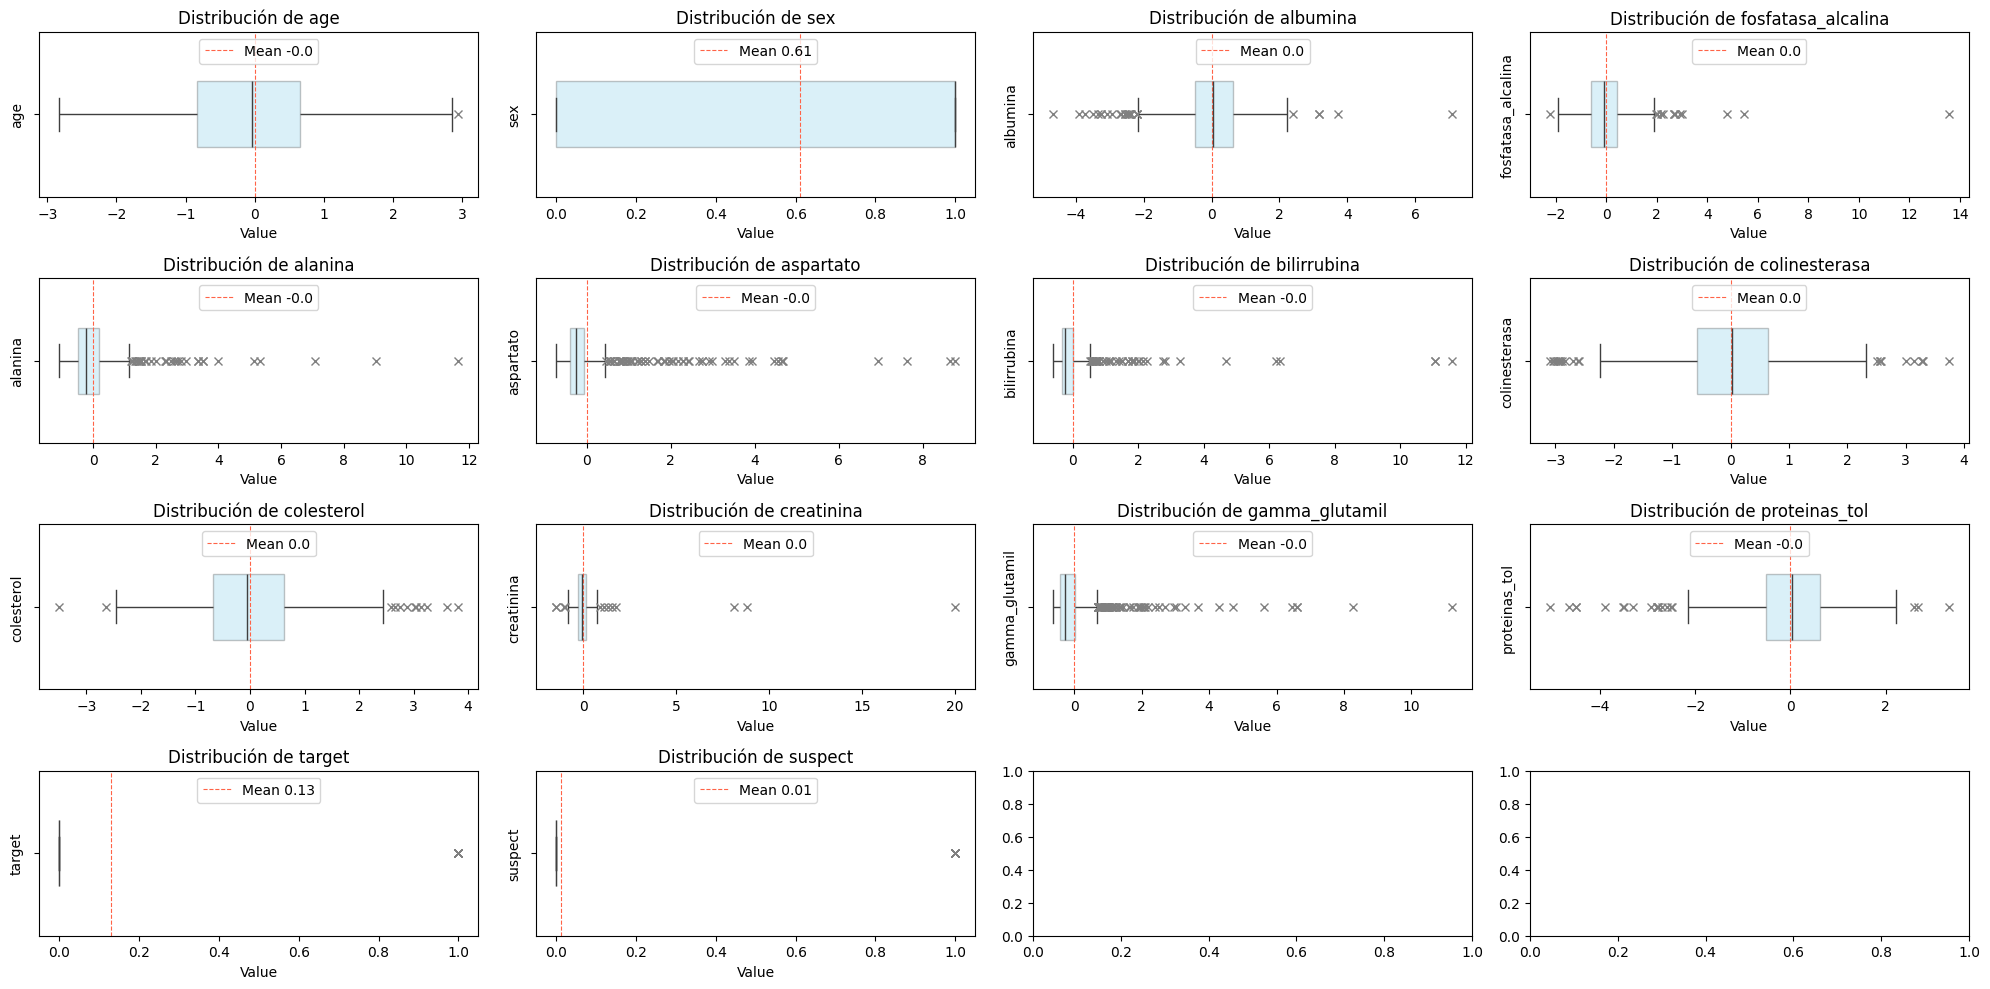

In [ ]:
get_graphics_uni(df,"Dataset Posterior a la estandarizacion")

**Haremos el train test split de 33% según lo indicado**

In [ ]:
#Definimos regresores y target
X = df.drop(columns="target")
y = df["target"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=16)
print(X_train.shape , X_test.shape, y_train.shape, y_test.shape)

(410, 13) (202, 13) (410,) (202,)


**Balancearemos las clases para la logistica con smote**

In [ ]:
#Instanciamos el oversampler
smote = SMOTE()

X_train_resampled, y_train_resampled = smote.fit_resample(X_train,y_train)

In [ ]:
y_train_resampled.value_counts("%")

target
0    0.5
1    0.5
Name: proportion, dtype: float64

# 2.Desarrolla un modelo regresión logística con validación cruzada usando 5-fold, con regularización Elastic Net. Busca para los siguientes hiper parámetros:

* Cs: valores entre 0.01 y 5.0, con 200 valores lineales.
* l1_ratio: valores entre 0 y 1, con 200 valores lineales.

IMPORTANTE: Luego de más de 7 hrs de búsqueda, el notebook cae y no permite acceder al resultado, ya que son más de 200.000 combinaciones las solicitadas y para extender el tiempo de ejecucion se necesita la version pro de Colab.

In [ ]:
%%time
# Creamos el diccionario de los hiperparámetros
elastic_params = {
    "penalty": ["elasticnet"],
    "C": np.linspace(0.01, 5.0, 200),
    "l1_ratio": np.linspace(0, 1, 200)
}

# Estimador
logistic = LogisticRegression(solver='saga', max_iter=10000,random_state=16)#Manejamos el desbalance dentro

# Instanciamos la grilla
grid_search = GridSearchCV(logistic, [elastic_params], cv=5,n_jobs=-1,verbose=1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Obtenemos los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Mejores hiperparámetros encontrados:", best_params)
print("Mejor score encontrado:", best_score)

# Entrenamos un nuevo modelo con los mejores hiperparámetros en el conjunto completo de entrenamiento
logistic_opt = LogisticRegression(solver='saga', max_iter=10000, **best_params,random_state=16)
logistic_opt.fit(X_train_resampled, y_train_resampled)


In [ ]:
#Hacemos las predicciones
def predict_metrics(model,X_train,X_test,y_train,y_test): #Definimos una funcion para optimizar codigo adelante

  model.fit(X_train,y_train)
  #Realizamos predicciones en train y test
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)

  #================TRAIN======================================
  #Calculamos metricas de desempeño de TRAIN
  conf_matrix_train = confusion_matrix(y_train, y_pred_train)
  report_train = classification_report(y_train, y_pred_train)

  #AUC-ROC / AUC-PR TRAIN
  roc_train = roc_auc_score(y_train, y_pred_train)
  pr_train = average_precision_score(y_train, y_pred_train)

  #================TEST======================================

  #Calculamos metricas de desempeño de TEST
  conf_matrix_test = confusion_matrix(y_test, y_pred_test)
  report_test = classification_report(y_test, y_pred_test)

  #AUC-ROC / AUC-PR TRAIN
  roc_test = roc_auc_score(y_test, y_pred_test)
  pr_test = average_precision_score(y_test, y_pred_test)


  #========================= OUTPUT =========================
  print("====================EVALUACION TRAIN ===============")
  print("Matriz de Confusión: TRAIN")
  print()
  print(conf_matrix_train)
  print()
  print("Reporte de clasificacion: TRAIN")
  print(report_train)
  print(f"AUC-ROC PARA TRAIN: {roc_train}")
  print(f"AUC-PR PARA TRAIN: {pr_train}")
  print()


  print("====================EVALUACION TEST ===============")
  print("Matriz de Confusión: TEST")
  print()
  print(conf_matrix_test)
  print()
  print("Reporte de clasificacion: TEST")
  print(report_test)
  print(f"AUC-ROC PARA TEST: {roc_test}")
  print(f"AUC-PR PARA TEST: {pr_test}")

Printearemos y compararemos sus metricas en el punto 4.****

# 3.Implementa un modelo Extreme Gradient Boosting con búsqueda de hiper parámetros de grilla, con regularización para la combinación L1 y L2. Considera para esto:

* a. reg_lambda: valores entre 0.0 y 2.0, con 10 valores lineales.
* b. reg_alpha: valores entre 0 y 1, con 10 valores lineales.
* c. learning_rate: valores entre 0.1 a 10, con 20 valores lineales.

Usaremos el parametro scal_pos_weight para manejar el desbalance de clases de la data y asi no utilizar data sintetica como SMOTE.

In [ ]:
%%time
# Creamos el diccionario de los hiperparámetros
xgb_params = {"reg_lambda": np.linspace(0.0,2.0,10),
              "reg_alpha": np.linspace(0,1,10),
              "learning_rate": np.linspace(0.1,10,20)}

#Estimador
xgb = XGBClassifier(scale_pos_weight=6,_random_state=16) #Aplicamos 6 de peso a la clase minoritaria ya que es aprox, 6 veces menor.

#Instanciamos la grilla
xgb_grid = GridSearchCV(xgb,xgb_params,cv=10,n_jobs=-1,verbose=1)#Usaremos 10 folds en vez de 5 para mejorar el overfitting encontrado en las primeras iteraciones
xgb_grid.fit(X_train,y_train)

#Obtenemos los mejores hiperparametros y score
xgb_best_params = xgb_grid.best_params_
xgb_best_score = xgb_grid.best_score_
print("Mejores hiperparámetros encontrados:", xgb_best_params)
print("Mejor score encontrado:", xgb_best_score)

# Entrenamos un nuevo modelo con los mejores hiperparámetros en el conjunto completo de entrenamiento
xgb_opt = XGBClassifier(scale_pos_weight=6,random_state=16,**xgb_best_params)
xgb_opt.fit(X_train, y_train)

Fitting 10 folds for each of 2000 candidates, totalling 20000 fits
Mejores hiperparámetros encontrados: {'learning_rate': 1.142105263157895, 'reg_alpha': 0.3333333333333333, 'reg_lambda': 1.7777777777777777}
Mejor score encontrado: 0.978048780487805
CPU times: user 58.5 s, sys: 2.73 s, total: 1min 1s
Wall time: 13min 32s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:09:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "_random_state" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.142105263157895,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=16, ...)

Printearemos y compararemos sus metricas en el punto 4.****

# 4.Muestra el nivel de importancia de los atributos, los valores óptimos de los hiper parámetros y las métricas precisión, recall, f1-score y accuracy. Compara los resultados de este modelo con el de regresión logística.

In [ ]:
predict_metrics(logistic_opt,X_train,X_test,y_train,y_test)

In [ ]:
predict_metrics(xgb_opt,X_train,X_test,y_train,y_test)

====================EVALUACION TRAIN ===============
Matriz de Confusión: TRAIN

[[362   0]
 [  0  48]]

Reporte de clasificacion: TRAIN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       362
           1       1.00      1.00      1.00        48

    accuracy                           1.00       410
   macro avg       1.00      1.00      1.00       410
weighted avg       1.00      1.00      1.00       410

AUC-ROC PARA TRAIN: 1.0
AUC-PR PARA TRAIN: 1.0

====================EVALUACION TEST ===============
Matriz de Confusión: TEST

[[170   1]
 [  9  22]]

Reporte de clasificacion: TEST
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       171
           1       0.96      0.71      0.81        31

    accuracy                           0.95       202
   macro avg       0.95      0.85      0.89       202
weighted avg       0.95      0.95      0.95       202

AUC-ROC PARA TEST: 0.851914

**Observamos las features importance de XGB**

In [ ]:
def get_importances(model):# Feature importances
  importances = model.feature_importances_
  columns = X_train.columns
  importances_sorted = np.argsort(importances)[::-1]

  plt.figure(figsize=(8, 6))
  bar_plot = sns.barplot(x=columns[importances_sorted], y=importances[importances_sorted],alpha=0.5)
  bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45, ha="right")
  plt.tight_layout()
  plt.show()

<ipython-input-32-595c4f78fa51>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45, ha="right")


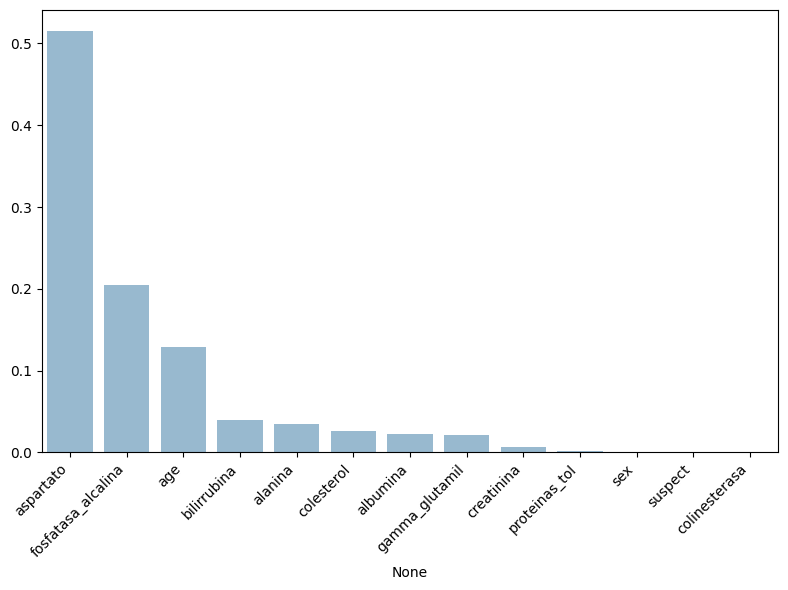

In [ ]:
get_importances(xgb_opt)

**Observaciones: Como podemos apreciar en el grafico, variables como age,proteinas total, colinesterasa, suspect y sex no son consideradas de manera reiterativa en las iteraciones del modelo para predecir la presencia o no de enfermedad en sangre, por lo que solo para verificar si podemos reducir el overfitting, filtraremos las features y volveremos a testear. Este punto no es solicitado en el desafio, pero es solo para intentar mejorar el modelo.**

In [ ]:
#Luego de muchas iteraciones, solo nos quedamos con las 2 variables más importantes, al final de las predicciones abajo hay comentarios.
X_train_selected = X_train[["aspartato","alanina","fosfatasa_alcalina","gamma_glutamil","colesterol"]]
X_test_selected = X_test[["aspartato","alanina","fosfatasa_alcalina","gamma_glutamil","colesterol"]]

# Entrenamos un nuevo modelo con los mejores hiperparámetros en el conjunto de variables seleccionadas
xgb_opt_sel = XGBClassifier(scale_pos_weight=6,random_state=16,**xgb_best_params)
xgb_opt_sel.fit(X_train_selected, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.142105263157895,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=16, ...)

In [ ]:
predict_metrics(xgb_opt_sel,X_train_selected,X_test_selected,y_train,y_test)

====================EVALUACION TRAIN ===============
Matriz de Confusión: TRAIN

[[362   0]
 [  0  48]]

Reporte de clasificacion: TRAIN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       362
           1       1.00      1.00      1.00        48

    accuracy                           1.00       410
   macro avg       1.00      1.00      1.00       410
weighted avg       1.00      1.00      1.00       410

AUC-ROC PARA TRAIN: 1.0
AUC-PR PARA TRAIN: 1.0

====================EVALUACION TEST ===============
Matriz de Confusión: TEST

[[169   2]
 [  4  27]]

Reporte de clasificacion: TEST
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       171
           1       0.93      0.87      0.90        31

    accuracy                           0.97       202
   macro avg       0.95      0.93      0.94       202
weighted avg       0.97      0.97      0.97       202

AUC-ROC PARA TEST: 0.929635

**Observaciones XGB con feature selection**:

Como podemos observar, el rendimiento del XGB aumentó de manera notable en la data de test luego de la seleccion de caracteristicas, con poco error de tipo 1 y 2, buen f1 score de 90% del target 1, precision global de 97% y buenas metricas de AUC-ROC y PR,además se redujo el overfitting  de una forma en train, lo que nos revela que la mayoria de las variables descartadas, solo aportaban ruido al modelo, por lo que este mismo es capaz de predecir solo con los 5 atributos con mayor importancia para  el target, aún teniendo clases desbalanceadas, ya que aplicamos un parametro interno de peso por clase, por lo que lo validamos como el mejor modelo para poder predecir enfermedad en sangre por sus métricas y su tiempo computacional bajo.Tambien es importante indicar que se aplicaron 10 folds de CV.

A este último modelo le aplicamos todas las formas para reducir el overfitting: CrossValidation, Feature selection y Regularizacion.